In [119]:
import numpy as np
import torch
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
import os
import time

class ModelVoxel(torch.nn.Module):
    def __init__(self, data, device='cpu'):
        super().__init__()
        self.data = torch.nn.Parameter(torch.tensor(data).to(device))
        
    @property
    def Ns(self):
        return self.data.shape
    @property
    def D(self):
        return len(self.data.shape)
        
    def forward(self, x):
        for i in range(self.D):
            x[:,i] = x[:,i].clamp(0, self.Ns[i]).long()
        return self.data[list(x.T)]

In [120]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [121]:
# # Importing drive method from colab for accessing google drive
# from google.colab import drive
# import glob
# drive.mount('/content/drive')
# data_files = glob.glob("/content/drive/My Drive/*.mat")

In [122]:
# data_path = '/content/drive/My Drive/' 
data_path = '/home/ab/Documents/DISK2TB/SaudiAramco/3D_geoproject/data/' 

In [123]:
tresh = 127
data3d = (loadmat(data_path+'Normal_1_0.5.mat')["ctImage"] > tresh).astype(np.float)
#bwImage = rawMatData["bwImage"]
# ctImage = rawMatData["ctImage"]

sublattice = [slice(None,256,4)]*3

In [124]:
data3d = data3d[sublattice]

<ipython-input-124-6037d64d9077>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data3d = data3d[sublattice]


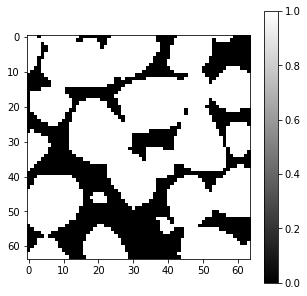

In [125]:
selection = (slice(None), slice(None), 12)

plt.figure(figsize=(5,5))
plt.imshow(data3d[selection],  cmap='gray')
plt.colorbar();

In [126]:
from ipypb import ipb
tqdm_notebook = ipb
import time

In [127]:
from torch.utils.data import Dataset, DataLoader

class discreteDataset(Dataset):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __len__(self):
        return np.prod(self.shape)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [128]:
torch_data = torch.tensor(data3d).to(device)

In [129]:
from tqdm import tqdm_notebook

In [130]:
model = ModelVoxel( torch.zeros_like(torch_data), device=device)

ds = discreteDataset(shape=data3d.shape)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds),
    batch_size=2**12,
    drop_last=False)

dl = DataLoader(ds, sampler=sampler)

<ipython-input-119-a7169f7e4a19>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.nn.Parameter(torch.tensor(data).to(device))


In [131]:
# L = torch.nn.BCELoss()
L = torch.nn.BCEWithLogitsLoss()
# L = torch.dist
n_epochs = 10
    
losses = []

for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    for epoch in ipb(range(n_epochs)):
        #print(epoch)
        for x in dl:
            optimizer.zero_grad()
            indices = torch.stack(x, dim=1).squeeze().T
            y_goal = torch_data[list(indices.T)]
            y_predicted = model(indices)
            loss = L(y_predicted, y_goal)
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.detach())

 [████████████████████████████████████████████████████████████] 10/10 [00:03<00:00, 0.29s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:03<00:00, 0.31s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:03<00:00, 0.28s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:03<00:00, 0.28s/it]

In [ ]:
def statmoments(data):
    mu = torch.sum(data) / torch_data.numel()

In [ ]:
def spacial_moments(data):
    M = torch.sum(data) / torch_data.numel()

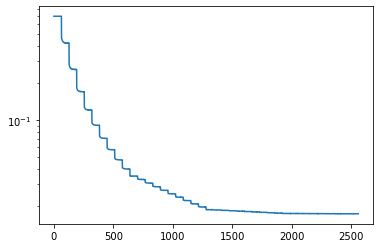

In [132]:
plt.semilogy(losses)

Text(0.5, 1.0, 'Data')

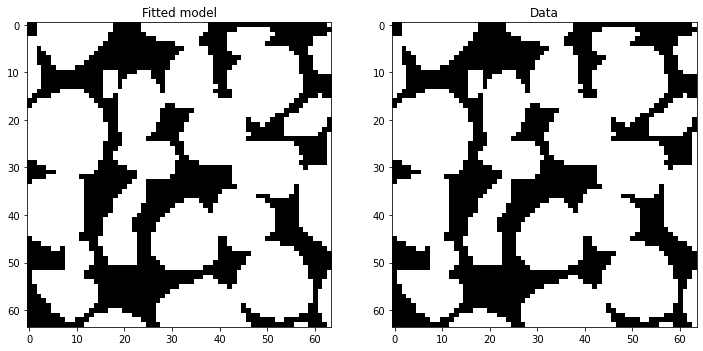

In [134]:
selection = [slice(None), slice(None), 31]
f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model.data[selection].sigmoid().detach().cpu().round(), cmap='gray')
axs[0].set_title("Fitted model")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")

## Looking at Fourier harmonics

In [35]:
import scipy

In [36]:
torch_data2d = torch_data[selection].detach().cpu()

In [37]:
fou = scipy.fft.fftn(torch_data2d.cpu().numpy())

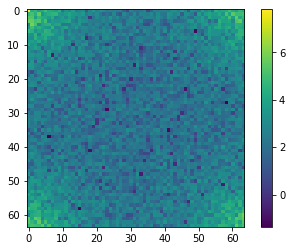

In [38]:
plt.imshow(np.log(np.abs(fou)))
plt.colorbar()

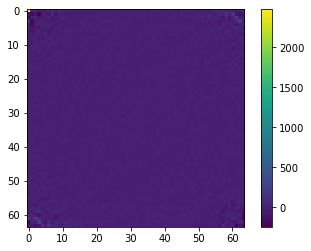

In [108]:
plt.imshow(np.real(fou))
plt.colorbar()

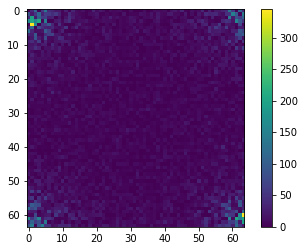

In [107]:
plt.imshow(np.abs(np.imag(fou)))
plt.colorbar()

# Sliced dataset

In [135]:
from torch.utils.data import Dataset, DataLoader

class SlicedDataset(Dataset):
    def __init__(self, shape, mask):
        super().__init__()
        self.shape = shape
        self.mask = mask
        self.indices = np.arange(np.prod(shape))[mask.flatten()]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [136]:
# select central slices

mask = np.zeros_like(data3d, dtype=np.bool)
Nx, Ny, Nz = data3d.shape
mask[Nx//2,:,:] = True
mask[:,Ny//2,:] = True
mask[:,:,Nz//2] = True
ds_slices = SlicedDataset(data3d.shape, mask)

In [137]:
Z = np.prod(torch_data.shape)

In [139]:
model = torch.nn.Sequential(
                        ModelVoxel(torch.ones_like(torch_data), device=device),
#                         torch.nn.Sigmoid()
)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2**14,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)


def optimize(model, dataloader):
    # L = torch.nn.BCELoss()
#     L = torch.nn.BCEWithLogitsLoss()

    L2 = torch.nn.MSELoss()
    Z = np.prod(torch_data.shape)   
    
    # L = torch.dist
    n_epochs = 10
    m0 = 1e-10
    m1 = 1e+2
    m2 = 1e-2
    losses = []

    for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        for epoch in ipb(range(n_epochs)):
            for x in dataloader:
                optimizer.zero_grad()
                indices = torch.stack(x, dim=1).squeeze().T
                y_goal = torch_data[list(indices.T)]
                y_predicted = model(indices)
                loss = m0*L(y_predicted, y_goal) + \
                m1*L2(torch_data.sum()/Z, model[0].data.sigmoid().sum()/Z) # + \
#                 -m2* ((.5-model[0].data.sigmoid())**2).sum()
                
                loss.backward(retain_graph=True)
                optimizer.step()
                losses.append(loss.detach())
    return losses

<ipython-input-119-a7169f7e4a19>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.nn.Parameter(torch.tensor(data).to(device))


In [140]:
losses = optimize(model, dl)

 [████████████████████████████████████████████████████████████] 10/10 [00:00<00:00, 0.01s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:00<00:00, 0.01s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:00<00:00, 0.01s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:00<00:00, 0.01s/it]

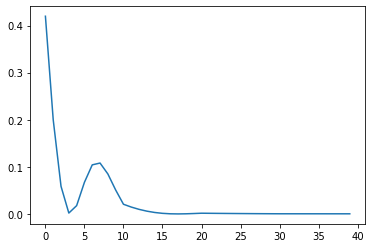

In [141]:
plt.plot(torch.stack(losses).cpu() )

Text(0.5, 1.0, 'Data')

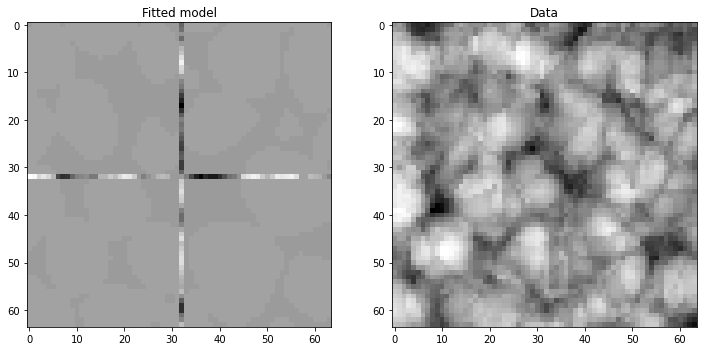

In [148]:
selection = [slice(None),  32, slice(None)]

f, axs = plt.subplots(1, 2, figsize=(12,12))
axs[0].imshow(model[0].data.sigmoid().sum(dim=0).detach().cpu(), cmap='gray')
axs[0].set_title("Fitted model")
axs[1].imshow(torch_data.sum(dim=0).detach().cpu(), cmap='gray')
axs[1].set_title("Data")

Text(0.5, 1.0, 'Data')

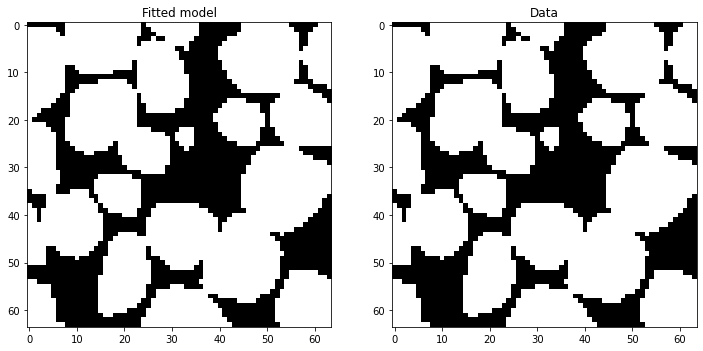

In [149]:
selection = [slice(None),  32, slice(None)]

f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model[0].data[selection].detach().cpu(), cmap='gray')
axs[0].set_title("Fitted model")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")

Text(0.5, 1.0, 'Data')

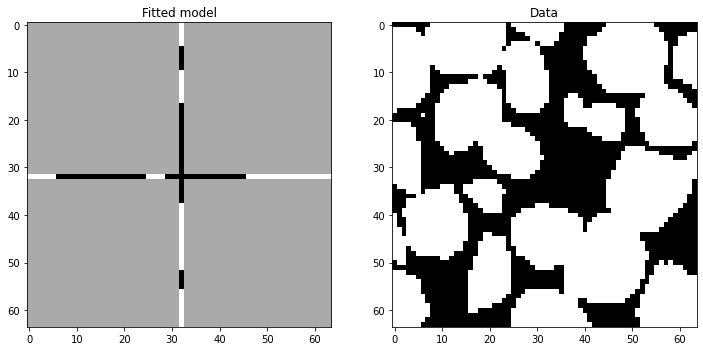

In [150]:
selection = [slice(None),  31, slice(None)]

f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model[0].data[selection].detach().cpu(), cmap='gray')
axs[0].set_title("Fitted model")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")

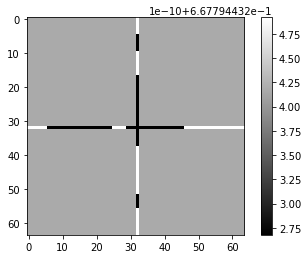

In [151]:
plt.imshow(model[0].data[selection].detach().cpu().sigmoid(), cmap='gray')
plt.colorbar()

In [152]:
model[0].data.detach().cpu().sigmoid().sum() / Z

tensor(0.6678, dtype=torch.float64)

In [153]:
torch_data.detach().cpu().sigmoid().sum() / Z

tensor(0.6539, dtype=torch.float64)

### random slices along z axis

In [104]:
# random slices along z axis

N_slices_per_axis = 10
centers = np.random.randint(Nx, size=(N_slices, 3))

mask = np.zeros_like(data3d, dtype=np.bool)
Nx, Ny, Nz = data3d.shape
mask[centers[:,0],:,0] = True
mask[:,centers[:,1],:] = True
mask[:,:,centers[:,-1]] = True
ds_slices = SlicedDataset(data3d.shape, mask)

NameError: name 'N_slices' is not defined

In [105]:
# model = ...

In [106]:
# losses = optimize(model, dl)